In [11]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from utils import run_simulation
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

In [12]:
# USER SETTINGS
n_sims = 10_000
periods = 252
n_years = 30
burn_in = periods * 30
max_leverage = 5.0
min_leverage = 0.0
f = 0.5
Rebalancing = 252
sharpe = "constant"
annual_ret = 0.15
expected_return = "known"
expected_vol = "known"
estimation_period = 10
SR = 0.55 
tc = 0.000
return_paths = True
return_excel_file = False

p_LL = 0.995
p_HH = 0.99
vol_low_annual = 0.12
vol_high_annual = 0.3
rho = 0.95
std_lns = 0.05
jumps_per_year = 0.5
jump_prob = 1 - np.exp(-jumps_per_year * (1 / periods))
jump_size = 0.30


c = SR / np.sqrt(periods)

output_file = "Stats.xlsx"
wealth_file = "LogWealth_Drawdowns.xlsx"


if __name__ == "__main__":

    # Use tqdm with joblib
    all_metrics = []
    kelly_wealth = []
    bh_wealth = []
    vol_wealth = []

    with tqdm_joblib(tqdm(total=n_sims, desc="Running simulations", ncols=100)) as progress_bar:
        results = Parallel(n_jobs=6)(
    delayed(run_simulation)(
        sim,
        n_years,
        periods,
        burn_in,
        p_LL,
        p_HH,
        vol_low_annual,
        vol_high_annual,
        rho,
        std_lns,
        jump_prob,
        jump_size,
        c,
        annual_ret,
        sharpe,
        f,
        min_leverage,
        max_leverage,
        Rebalancing,
        return_paths,
        tc,
        estimation_period,
        expected_return,
        expected_vol
    )
    for sim in range(n_sims)
)
    
    # Separate the results into summary and wealth
    for metrics, kelly_w, bh_w, vol_w in results:
        all_metrics.append(metrics)
        kelly_wealth.append(kelly_w)
        bh_wealth.append(bh_w)
        vol_wealth.append(vol_w)

    # Save the summary
    summary_df = pd.DataFrame(all_metrics).set_index("sim")
    

    # Save the wealth distributions
    wealth_df = pd.DataFrame({
        "half-Kelly Final Log Wealth": kelly_wealth,
        "Half-kelly Max Drawdown": [m['Half-kelly Max Drawdown'] for m in all_metrics],
        "Buy-and-Hold Final Log Wealth": bh_wealth,
        "Buy-and-Hold Max Drawdown": [m['Buy-and-Hold Max Drawdown'] for m in all_metrics],
        "Volatility Targeting Final Log Wealth": vol_wealth,
        "Volatility Targeting Max Drawdown": [m['Volatility Targeting Max Drawdown'] for m in all_metrics],
    })

    if return_excel_file:
        wealth_df.to_excel(wealth_file, index=False)
        print(f"Wealth distributions saved to {wealth_file}")
        summary_df.describe().round(4).to_excel(output_file)
        print(f"Summary saved to {output_file}")


  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
# Compute column means
means = summary_df.mean(numeric_only=True)

# Build the 4x3 matrix
matrix_data = {
    "Half-Kelly": [
        means["half-Kelly Final Log Wealth"],
        means["Half-kelly Max Drawdown"],
        means["half-kelly SR"],
        means["half-Kelly weight"]
    ],
    "Volatility Targeting": [
        means["Volatility Targeting Final Log Wealth"],
        means["Volatility Targeting Max Drawdown"],
        means["Volatility Targeting SR"],  
        means["Volatility Targeting weight"]
    ],
    "Buy-and-Hold": [
        means["Buy-and-Hold Final Log Wealth"],
        means["Buy-and-Hold Max Drawdown"], 
        means["Buy-and-Hold SR"],
        1.0  # No weight column for Buy-and-Hold
    ]
}

# Create a DataFrame
summary_matrix = pd.DataFrame(matrix_data, index=[
    "Final Log Wealth",
    "Max Drawdown",
    "Sharpe Ratio",
    "Average Weight"
])

# Display the result
print("\nMean Metrics Summary (4x3 Matrix):\n")
print(summary_matrix.round(3))


Mean Metrics Summary (4x3 Matrix):

                  Half-Kelly  Volatility Targeting  Buy-and-Hold
Final Log Wealth       3.396                 2.673         2.372
Max Drawdown          -0.621                -0.494        -0.514
Sharpe Ratio           0.549                 0.549         0.498
Average Weight         1.810                 1.300         1.000


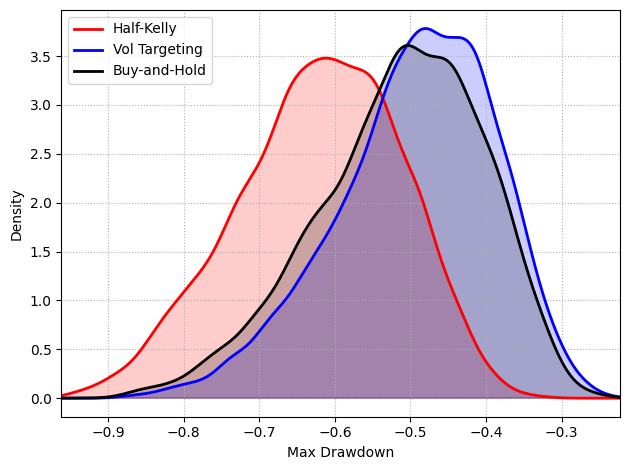

In [14]:
# Compute and sort difference in max drawdowns (Figure 6)
diff = wealth_df['Half-kelly Max Drawdown'] - wealth_df['Buy-and-Hold Max Drawdown']
diff_sorted = diff.sort_values()

# KDE plot
ax = wealth_df[['Half-kelly Max Drawdown', 'Volatility Targeting Max Drawdown', 'Buy-and-Hold Max Drawdown']].plot(
    kind='kde', linewidth=2, color=['red', 'blue', 'black']
)

# Set x-axis limits
xmin, xmax = wealth_df[['Half-kelly Max Drawdown', 'Volatility Targeting Max Drawdown', 'Buy-and-Hold Max Drawdown']].min().min(), \
             wealth_df[['Half-kelly Max Drawdown', 'Volatility Targeting Max Drawdown', 'Buy-and-Hold Max Drawdown']].max().max()
ax.set_xlim(xmin, xmax)

# Fill under the KDE curves
for col, color in zip(
    ['Half-kelly Max Drawdown', 'Volatility Targeting Max Drawdown', 'Buy-and-Hold Max Drawdown'],
    ['red', 'blue', 'black']
):
    kde = wealth_df[col].plot(kind='kde', linewidth=2, color=color, alpha=0)
    x = kde.get_lines()[-1].get_xdata()
    y = kde.get_lines()[-1].get_ydata()
    ax.fill_between(x, y, color=color, alpha=0.2)

# Formatting
ax.set_xlabel("Max Drawdown")
ax.set_ylabel("Density")
ax.legend(['Half-Kelly', 'Vol Targeting', 'Buy-and-Hold'])
ax.grid(True, linestyle=':')

# Save and show plot
plt.tight_layout()
plt.show()


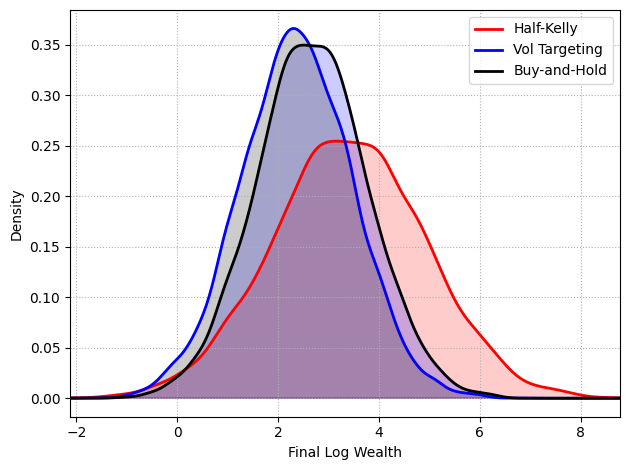

In [15]:
# KDE plot for final log wealth (Figure 5)
ax2 = wealth_df[['half-Kelly Final Log Wealth', 'Buy-and-Hold Final Log Wealth', 'Volatility Targeting Final Log Wealth']].plot(
    kind='kde', linewidth=2, color=['red', 'blue', 'black']
)

# Set x-axis limits
xmin2, xmax2 = wealth_df[['half-Kelly Final Log Wealth', 'Volatility Targeting Final Log Wealth', 'Buy-and-Hold Final Log Wealth']].min().min(), \
               wealth_df[['half-Kelly Final Log Wealth', 'Volatility Targeting Final Log Wealth', 'Buy-and-Hold Final Log Wealth']].max().max()
ax2.set_xlim(xmin2, xmax2)

# Fill under the KDE curves
for col, color in zip(
    ['half-Kelly Final Log Wealth', 'Volatility Targeting Final Log Wealth', 'Buy-and-Hold Final Log Wealth'],
    ['red', 'blue', 'black']
):
    kde2 = wealth_df[col].plot(kind='kde', linewidth=2, color=color, alpha=0)
    x2 = kde2.get_lines()[-1].get_xdata()
    y2 = kde2.get_lines()[-1].get_ydata()
    ax2.fill_between(x2, y2, color=color, alpha=0.2)

# Formatting
ax2.set_xlabel("Final Log Wealth")
ax2.set_ylabel("Density")
ax2.legend(['Half-Kelly', 'Vol Targeting', 'Buy-and-Hold'])
ax2.grid(True, linestyle=':')

# Save and show plot
plt.tight_layout()
plt.show()
